In [1117]:
import json
import numpy as np
import matplotlib.pyplot as plt
import time
import copy

debug_level = 0
float_formatter = "{:.2f}".format
np.set_printoptions(formatter={'float_kind':float_formatter})

# Aggregation of all line solutions, represented as statistical distribution 
# 1.0 - always set,  -1.0 - always unset 
class Variants:
    def __init__(self, variants):
        self.aggregate = None
        self.count = 0
        for var in variants:
            if self.aggregate is None:
                self.aggregate = np.zeros((var.sum()))
            self.aggregate += var.unpack()
            self.count += 1
        if self.count:
            self.aggregate /= self.count
    def __repr__(self):
        return f"Variants {self.aggregate}"
        
# Packed representation of one line solution
# Even colums represent unset field, odd colums represent set fields
# [0, 1, 3, 2] represents [.X...XX]
class Variant:
    unpacks_done = 0
    def __init__(self, list):
        self.list = list
        self.unpacked = None
    def __repr__(self):
        return f"Variant {self.str()} {[x for x in self.list]}"
    def str(self):
        out = ""
        for i in self.unpack():
            out += 'X' if i == 1 else '.'
        return out
    def sum(self):
        return sum(self.list)
    # Unpack to array where 1: occupied, 0: empty
    def unpack(self):
        if self.unpacked is None:
            self.unpacked = np.zeros(sum(self.list))
            index = 0
            for i in range(len(self.list)):
                for j in range(self.list[i]):
                    self.unpacked[index] = 1 if i%2 else -1
                    index += 1
            Variant.unpacks_done += 1
        return self.unpacked
    
    # Is compatible with already laid down pieces?
    def can_fit(self, known_pieces):
        if not len(known_pieces): return True
        unpacked = self.unpack()
        for i,j in zip(unpacked, known_pieces):
            if (j+i==0): return False   # unpacked can be only 1 or -1. Zero can happen if the other is opposite
        return True
    
        
# Given specification of one line (row or column). E.g. [1,5,2]
class Seq:
    def __init__(self, list):
        self.list = list
        self.allvariants = None
        self.known_pieces = None
    def __repr__(self):
        return f"Seq {self.list}"
    # partial - partially built list of this combination
    # Note that valid_variants will actually remove the already illegal variants from the cached pool
    def variants(self, width, known_pieces=[], remove_invalid=False, partial=[]):  
        if self.known_pieces is not None:
            for k1, k2 in zip (self.known_pieces, known_pieces):
                if k1 != 0 and k1 != k2:
                    raise Exception("Can't iterate with less known pieces than before, variants were already removed")
        if self.allvariants is None:
            self.allvariants = [variant for variant in self.gather_variants(width, known_pieces, partial) if variant.can_fit(known_pieces)]
            print(f'Generated {len(self.allvariants):>6d} variants for assumed complexity {{{self.variant_count(width)}|{self.variant_discount(width, known_pieces):.1f}}}')

        goodvariants = []
        for variant in self.allvariants:
            if variant.can_fit(known_pieces): 
                yield variant 
                if remove_invalid:
                    goodvariants.append(variant)
        self.known_pieces = np.copy(known_pieces)
        if remove_invalid:
            self.allvariants = goodvariants
            
        
    def gather_variants(self, width, known_pieces, partial=[]):  
        if debug_level > 2: print(f'remain={self.list}, partial={partial}')
        if not Variant(partial).can_fit(known_pieces):
            return
        if not self.list:
            # Successfully emptied all requirements
            finished = Variant(partial + [width - sum(partial)])
            if finished.can_fit(known_pieces):
                yield finished
            return
        # Item that will be placed
        first = self.list[0]
        # Minimum space needed to fit all the remaining ones
        reserved = sum(self.list[1:]) + len(self.list[1:])
        for i in range(0 if not partial else 1, 1 + width - (first + reserved + sum(partial))):
            yield from Seq(self.list[1:]).gather_variants(width, known_pieces, partial + [i, first])
    
    def variant_count(self, width):
        space, needles = (width - (len(self.list)-2 + sum(self.list)), len(self.list))
        if space < 1: return 0
        # print(f'{space=},{needles=}')
        return int(np.math.factorial(space + needles - 1) / (np.math.factorial(space-1) * np.math.factorial(needles)))
    
    # Variant count discounted by the number of known pieces - %SALE %SALE %SALE!
    def variant_discount(self, width, known_pieces):
        if hasattr(known_pieces, '__iter__'): 
            known_pieces = np.count_nonzero(known_pieces)
        return self.variant_count(width) * 0.8**known_pieces  # Definitely not exact. The exact distribution matters here.
         # But we don't need exact, just useful and fast enough to choose the next cheap step!

    # Try the obvious step - if there are known pieces all the way from any border, fill in gaps without getting all the variants
    def fill_obvious(self, width, known_pieces):
        changed, known_pieces = fill_obvious_list(self.list, known_pieces)
        changed_r, known_pieces = fill_obvious_list(self.list[::-1], known_pieces[::-1])
        return changed or changed_r, known_pieces[::-1]
        
def fill_obvious_list(list, known_pieces):
    if not len (list):
        return (False, known_pieces)
    islands = iter(list)
    val = -1  # Currently iterated value
    count = 0 # Number of occurrences so far
    pos = 0   # Position in known_pieces
    did_change = False
    for piece in known_pieces:
        if piece == val:
            # Continue accumulating, still the same
            count += 1
        elif piece == -1 or piece == 1:
            # Different piece
            if piece == -1:
                if not island == count:
                    raise Exception('Invalid combination')
            else:
                island = next(islands)
            val = piece
            count = 1
        else:
            break
        pos += 1
    if val == 1 and island < count:
        raise Exception('Invalid combination')
    # We still have something to fill
    if pos != len(known_pieces) and val == 1:
        while island - count > 0:
            known_pieces[pos] = 1  # Fill rest of the island
            island -= 1
            pos += 1
            did_change = True
        if pos != len(known_pieces):
            known_pieces[pos] = -1  # Needs to terminate with empty
            did_change = True
    return (did_change, known_pieces)
        
        

# Solving matrix
class Field:
    def __init__(self, rows, cols):
        self.rows = rows
        self.cols = cols
        self.mat = np.zeros((len(self.rows), len(self.cols)))
        self.probs = self.mat.copy() # Probabilities
        self.npass = 0
        self.complexity = 0
        self.more_solutions = False
    def __repr__(self):
        return f'{self.mat}'
    def solve_step(self):
        self.complexity = 0
        while True:
            previous_mat = self.mat.copy()
            row_val, col_val = 1, 0

            # Find the least complex line - sort by complexity. It is only an approximation as also the shape, not just the count of 
            #  known pieces matters here. We're ignoring the shape for simplicity for now.
            lines = [(i,line,row_val,self.mat[i,:],line.variant_discount(self.mat.shape[row_val], np.count_nonzero(self.mat[i,:])))
                     for i,line in enumerate(self.rows)] + \
                    [(i,line,col_val,self.mat[:,i],line.variant_discount(self.mat.shape[col_val], np.count_nonzero(self.mat[:,i])))
                     for i,line in enumerate(self.cols)]
            lines = sorted(lines, key = lambda t: t[4]) # Sort by discount
            line_processed = None
            
            # Fill obvious pass - too much duplicity
            print(f'Complexities: {[int(candidate[4]) for candidate in lines]}')
            for i, line, is_row, known_pieces, complexity in lines:
                if not 0 in known_pieces or np.array_equal(line.known_pieces, known_pieces):
                    continue
                prev_pieces = copy.copy(known_pieces)
                length = self.mat.shape[is_row]
                filled, known_pieces = line.fill_obvious(length, known_pieces)
                if filled:
                    print(f'Did obvious fill in {"row" if is_row else "col"} {i} of {prev_pieces} into {known_pieces}')
       
            # Iterate from simplest to most complex and find the first line where we can delve some new information
            for i, line, is_row, known_pieces, complexity in lines:
                if line_processed is not None:
                    break # Last line did add some new information, restart from simplest ones
                if not 0 in known_pieces or np.array_equal(line.known_pieces, known_pieces):
                    continue # Already solved or same as before

                length = self.mat.shape[is_row]
                if line.allvariants is None: print(f'Generating all variants in {"row" if is_row else "col"} {i} with {known_pieces}')
                variants = Variants(line.variants(length, known_pieces, not self.more_solutions))
                if is_row: self.probs[i,:] = variants.aggregate 
                else: self.probs[:,i] = variants.aggregate

                if variants.aggregate is None:
                    return # There is no solution
                for j in range(len(variants.aggregate)):
                    prob = variants.aggregate[j]
                    if prob == -1 or prob == 1:
                        row = j if not is_row else i
                        col = i if not is_row else j
                        if (self.mat[row,col] != prob):
                            line_processed = line # = ((row, col), (self.mat[row,col], prob))
                            self.mat[row,col] = prob

                self.npass += 1
            if debug_level > 1: print(self.mat)
            changed = (previous_mat != self.mat).any()
            
            # Handle possibility we need to take a guess to continue
            if not changed and not self.is_solved():
                self.more_solutions = True
                guess = copy.copy(self)
                option1, option2 = self.take_a_guess()
                guess.mat = option1
                for advanced in guess.solve_step():
                    self.mat = guess.mat
                    if advanced:
                        yield advanced
                self.complexity += guess.complexity    
                if not self.is_solved():
                    # Guess did not work out, continue with the other option (as long there's only 2)
                    self.mat = option2
                    changed = True
                    
            if not changed:
                break
            yield (True, line_processed)
    
    def take_a_guess(self):
        for i in range(self.mat.shape[0]):
            for j in range(self.mat.shape[1]):
                if self.mat[i,j] == 0:
                    option1 = self.mat.copy()
                    option1[i,j] = 1
                    option2 = self.mat.copy()
                    option2[i,j] = 1
                    return (option1, option2)
    
    def is_solved(self):
        return not 0 in field.mat
    
    def last_complexity(self):
        return self.complexity
    
    def visualize(self):
        fig, ax = plt.subplots(figsize=(2, 8))
        ax.pcolormesh(self.mat, cmap='terrain_r')
        ax.set_aspect('equal')
        ax.set_xlim(0, self.mat.shape[1])
        ax.set_ylim(self.mat.shape[0], 0)
        plt.show()
        
    def visualize_probs(self):
        rows = [0 if row.allvariants is None else 1.0 for row in self.rows]
        rows = np.array(rows)
        rows = rows.reshape(len(rows), 1)
        
        cols = [0 if col.allvariants is None else 1.0 for col in self.cols]
        cols = np.array([0] + cols)
        cols = cols.reshape(1, len(cols))
        
        all = np.concatenate((rows, self.probs), axis=1)
        all = np.concatenate((cols, all), axis=0)
        fig, ax = plt.subplots(figsize=(2, 8))
        ax.pcolormesh(all, cmap='viridis_r')
        ax.set_aspect('equal')
        ax.set_xlim(0, all.shape[1])
        ax.set_ylim(all.shape[0], 0)
        # bx.pcolormesh(rows, cmap='terrain_r')
        plt.show()

In [1118]:
Seq([1,2,3]).fill_obvious(10, [1,-1,1,0,-1,0,0,0,0,1])

(True, [1, -1, 1, 1, -1, 0, -1, 1, 1, 1])

In [1119]:
debug_level = 1
sequence = [1,4,3,1]
vars = Variants(Seq(sequence).variants(30)) # All possibilities
print(f'Variants: {vars}, count: {vars.count}')
vars = Variants(Seq(sequence).variants(30, [0,0,0,0,0,0,0,0,0,1,0])) # All possibilities
print(f'Variants: {vars}, count: {vars.count}')

# print(Variants(Seq([2,1,1]).variants(7, [0, 0, 0, 1, -1, 0, 0 ]))) # Filtered by known pieces
# print(Variants(Seq([2,1,1]).variants(7, [0, 0, 0, 1, -1, -1, -1 ]))) # Filtered by known pieces
# print(Variants(Seq([2,2,2,2,2,5,5,2]).variants(50)))
print(Seq([2,2,2,2,2,5,5,2]).variant_count(50))
[variant for variant in Seq([1,1,1]).variants(7)]

elems = [3, 1, 2, 1]
width = 12
print(len([print(variant) for variant in Seq(elems).variants(width)]))
print(f'VarCount: {Seq(elems).variant_count(width)}')

Generated   7315 variants for assumed complexity {7315|7315.0}
Variants: Variants [-0.64 -0.69 -0.68 -0.63 -0.54 -0.43 -0.34 -0.28 -0.24 -0.21 -0.19 -0.18
 -0.17 -0.17 -0.18 -0.20 -0.22 -0.24 -0.27 -0.30 -0.33 -0.36 -0.40 -0.43
 -0.48 -0.54 -0.63 -0.68 -0.69 -0.64], count: 7315
Generated   2886 variants for assumed complexity {7315|5852.0}
Variants: Variants [-0.65 -0.69 -0.68 -0.64 -0.61 -0.69 -0.38 -0.05 0.34 1.00 0.42 0.04 -0.34
 -0.58 -0.39 -0.32 -0.31 -0.36 -0.39 -0.43 -0.47 -0.50 -0.54 -0.58 -0.62
 -0.67 -0.71 -0.74 -0.74 -0.72], count: 2886
4292145
Generated     10 variants for assumed complexity {10|10.0}
Generated     15 variants for assumed complexity {15|15.0}
Variant XXX.X.XX.X.. [0, 3, 1, 1, 1, 2, 1, 1, 2]
Variant XXX.X.XX..X. [0, 3, 1, 1, 1, 2, 2, 1, 1]
Variant XXX.X.XX...X [0, 3, 1, 1, 1, 2, 3, 1, 0]
Variant XXX.X..XX.X. [0, 3, 1, 1, 2, 2, 1, 1, 1]
Variant XXX.X..XX..X [0, 3, 1, 1, 2, 2, 2, 1, 0]
Variant XXX.X...XX.X [0, 3, 1, 1, 3, 2, 1, 1, 0]
Variant XXX..X.XX.X. [0, 3

In [1120]:
import requests
import re

def get_actual_puzzle(id):
    url = f'https://www.griddlers.net/en_US/nonogram/-/g/t1679057429974/i01?p_p_lifecycle=2&p_p_resource_id=griddlerPuzzle&p_p_cacheability=cacheLevelPage&_gpuzzles_WAR_puzzles_id={id}&_gpuzzles_WAR_puzzles_lite=false'
    r = requests.get(url)
    match = re.search("var puzzle =(.+)\n\nvar solution", r.text, re.DOTALL)
    js_object = match.group(1)
    # replace single quotes with double quotes
    js_object = js_object.replace("'", '"')
    # wrap keys with double quotes
    js_object = re.sub(r"(\w+)\s?:", r'"\1":', js_object)
    # wrap values with double quotes except for numbers or booleans
    js_object = re.sub(r":\s?(?!(\d+|true|false))(\w+)", r':"\2"', js_object)
    # eradicate continuation , on last element in list   <--  hacky, works only on this one ^_^
    js_object = re.sub(r'",\s*\n', r'"\n', js_object)
    barely_json = json.loads(js_object)
    
    # print(barely_json)
    rows = [[row[1] for row in rowses] for rowses in barely_json["leftHeader"]]
    cols = [[col[1] for col in colses] for colses in barely_json["topHeader"]]
    print(f'Downloaded nonogram {id} from the internets with {len(rows)} rows, {len(cols)} cols')
    return rows, cols

def get_test_puzzle(file):
    with open(file) as f:
        data = json.load(f)
    rows = data['rows']
    cols = data['columns']
    return rows, cols

Downloaded nonogram 266162 from the internets with 50 rows, 35 cols
Complexities: [6, 10, 10, 10, 10, 10, 15, 15, 20, 20, 20, 35, 36, 120, 165, 210, 210, 210, 252, 330, 330, 330, 364, 364, 455, 462, 462, 495, 495, 561, 715, 924, 969, 1287, 1716, 1820, 2380, 2380, 3003, 3003, 3060, 3060, 4368, 4495, 4845, 5005, 6188, 8008, 8008, 8855, 11440, 11628, 11628, 12870, 15504, 15504, 18564, 19448, 20349, 26334, 27132, 27132, 27405, 31824, 38760, 50388, 50388, 50388, 54264, 54264, 75582, 100947, 116280, 116280, 134596, 203490, 203490, 278256, 319770, 346104, 497420, 593775, 1081575, 1562275, 4292145]
Generating all variants in row 41 with [0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
 0.00 0.00 0.00 0.00 0.00 0.00 0.00]
Generated      6 variants for assumed complexity {6|6.0}
step 1, time taken so far: 0.004 s, complexity: 0


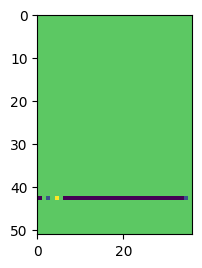

Complexities: [0, 10, 10, 10, 10, 10, 15, 15, 20, 20, 20, 35, 36, 120, 165, 210, 210, 210, 252, 291, 291, 330, 330, 330, 369, 455, 462, 495, 495, 561, 572, 924, 969, 1287, 1456, 1716, 2380, 2380, 2448, 3003, 3003, 3060, 4368, 4495, 4845, 4950, 5005, 6406, 7084, 8008, 9302, 11440, 11628, 12403, 12870, 14851, 15504, 15558, 16279, 21705, 21705, 25459, 26334, 27405, 38760, 40310, 40310, 43411, 43411, 50388, 75582, 80757, 93024, 93024, 107676, 162792, 203490, 276883, 278256, 319770, 497420, 593775, 865260, 1562275, 4292145]
Generating all variants in row 34 with [0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
 0.00 0.00 0.00 0.00 0.00 0.00 0.00]
Generated     10 variants for assumed complexity {10|10.0}
Complexities: [0, 0, 10, 10, 10, 10, 15, 15, 20, 20, 20, 35, 36, 120, 165, 210, 210, 210, 232, 252, 291, 295, 330, 330, 330, 455, 457, 462, 495, 495, 561, 924, 969, 1164, 1287, 1716, 1958, 2380, 238

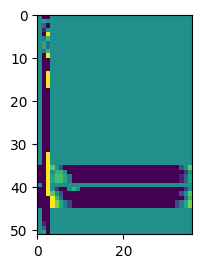

Complexities: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 12, 14, 21, 28, 62, 66, 76, 86, 95, 96, 96, 108, 108, 108, 132, 134, 134, 186, 202, 244, 316, 410, 455, 561, 591, 702, 823, 830, 969, 1074, 1188, 1218, 1523, 1537, 1560, 1566, 1921, 2050, 2080, 2236, 2480, 2491, 2610, 2624, 2731, 3641, 3641, 4271, 4685, 5953, 6589, 7283, 7283, 8453, 8453, 10786, 13548, 15297, 15606, 15606, 18065, 19845, 21924, 32248, 46453, 66679, 75582, 203490, 283528, 319770, 497420, 593775, 900128, 999856]
Generating all variants in row 38 with [1.00 -1.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
 0.00 0.00 0.00 0.00 0.00 0.00 0.00]
Generated     10 variants for assumed complexity {20|12.8}
Complexities: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 14, 21, 28, 49, 61, 66, 76, 86, 96, 96, 108, 108, 108, 132, 134, 134, 186, 195, 202, 316, 328, 455, 561, 591, 664, 702, 823, 859, 950, 969, 1218, 1248, 1523, 1537, 1566, 1664, 1921, 1993, 2050,

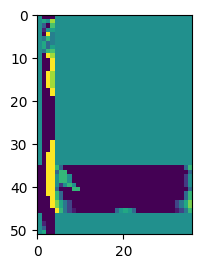

Complexities: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 23, 49, 61, 61, 61, 66, 76, 86, 96, 105, 107, 108, 108, 108, 134, 156, 202, 253, 262, 291, 531, 561, 591, 687, 702, 760, 823, 969, 1218, 1218, 1248, 1331, 1537, 1566, 1594, 1670, 1747, 1921, 2050, 2236, 2330, 2330, 2480, 2624, 2733, 4685, 5410, 5826, 5826, 5953, 6589, 8453, 9988, 9988, 10786, 10839, 11561, 15297, 19845, 21924, 29730, 32248, 53343, 75582, 203490, 283528, 319770, 497420, 593775, 900128, 999856]
Generating all variants in row 49 with [0.00 1.00 1.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
 0.00 0.00 0.00 0.00 0.00 0.00 0.00]
Generated     15 variants for assumed complexity {36|23.0}
Complexities: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 39, 49, 61, 61, 66, 76, 86, 96, 105, 107, 108, 108, 108, 134, 156, 202, 253, 262, 291, 531, 561, 591, 687, 702, 760, 823, 969, 998, 1218, 1218, 1331, 1336, 1398, 1537, 1566, 1594, 1864, 1921, 2

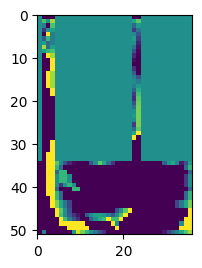

Complexities: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 2, 4, 20, 25, 42, 66, 68, 95, 96, 100, 108, 108, 134, 150, 160, 168, 174, 187, 202, 204, 224, 262, 281, 311, 317, 520, 561, 591, 653, 702, 779, 823, 852, 954, 1072, 1527, 1537, 1537, 1789, 1909, 2050, 2624, 2770, 3534, 3748, 4328, 4735, 4762, 5202, 5549, 6392, 6589, 7832, 15221, 21924, 27311, 32248, 75582, 145166, 203490, 319770, 460865, 497420, 593775, 999856]
Generating all variants in col 31 with [0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
 0.00 0.00 0.00 0.00 0.00 0.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00
 0.00 0.00 1.00 1.00 1.00 1.00 1.00 0.00]
Generated    144 variants for assumed complexity {364|20.0}
Complexities: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 2, 3, 5, 25, 34, 66, 68, 95, 96, 100, 108, 108, 134, 150, 160, 163, 168, 174, 187, 202, 210, 224, 281, 311, 317, 520, 561, 591, 653,

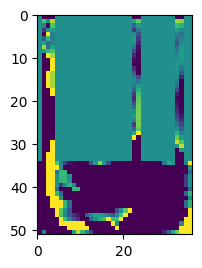

Complexities: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 2, 5, 6, 21, 66, 68, 68, 96, 100, 104, 108, 108, 134, 150, 160, 174, 187, 202, 203, 210, 224, 249, 281, 349, 473, 520, 561, 562, 653, 658, 779, 954, 1072, 1230, 1527, 1537, 1640, 1789, 1909, 2099, 2618, 2770, 3208, 3462, 3534, 3748, 4735, 4762, 5202, 5271, 5549, 12177, 21924, 27311, 32248, 75582, 145166, 203490, 294953, 319770, 497420, 593775, 999856]
Complexities: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 2, 5, 6, 21, 66, 68, 68, 96, 100, 104, 108, 108, 134, 150, 160, 174, 187, 202, 203, 210, 224, 249, 281, 349, 473, 520, 561, 562, 653, 658, 779, 954, 1072, 1230, 1527, 1537, 1640, 1789, 1909, 2099, 2566, 2618, 2770, 3462, 3534, 3748, 4735, 4762, 5202, 5271, 5549, 12177, 21924, 27311, 32248, 75582, 145166, 203490, 294953, 319770, 497420, 593775, 999856]
Complexities: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 2, 5, 6, 21, 66, 68, 68, 96, 100, 104, 108, 108, 

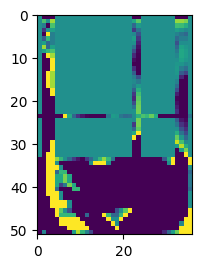

Complexities: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 2, 4, 5, 5, 51, 55, 62, 68, 104, 107, 108, 108, 139, 150, 159, 160, 162, 179, 187, 202, 210, 225, 279, 378, 449, 520, 527, 561, 610, 653, 779, 984, 1072, 1221, 1312, 1527, 1537, 1679, 1772, 1789, 2094, 2566, 2770, 3534, 3748, 4217, 4439, 4735, 4762, 5202, 12177, 17479, 21924, 32248, 59460, 75582, 203490, 235963, 319770, 497420, 593775, 999856]
Complexities: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 2, 5, 5, 49, 51, 55, 68, 104, 107, 108, 108, 139, 150, 159, 160, 162, 179, 187, 202, 210, 225, 279, 359, 378, 520, 527, 561, 610, 653, 779, 984, 1049, 1072, 1221, 1343, 1527, 1537, 1772, 1789, 2094, 2566, 2770, 3534, 3748, 4217, 4439, 4735, 4762, 5202, 12177, 17479, 21924, 32248, 59460, 75582, 203490, 235963, 319770, 497420, 593775, 999856]
Generating all variants in row 21 with [1.00 1.00 1.00 1.00 1.00 1.00 -1.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
 0.00 0.00 0.00 0.00 0.00 0.0

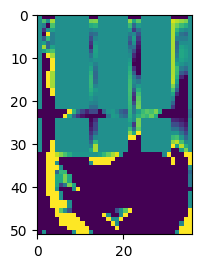

Complexities: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 2, 5, 11, 20, 40, 44, 52, 68, 73, 89, 104, 107, 108, 108, 134, 150, 160, 178, 179, 187, 202, 250, 267, 359, 378, 416, 527, 561, 580, 779, 977, 984, 1049, 1072, 1221, 1343, 1537, 1675, 1772, 1789, 2053, 2841, 3030, 3534, 3748, 4217, 4762, 5202, 7793, 11186, 21924, 32248, 38054, 75582, 151016, 203490, 319770, 497420, 593775, 999856]
Complexities: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 2, 5, 20, 32, 35, 52, 68, 73, 89, 104, 107, 108, 108, 134, 142, 150, 160, 179, 187, 202, 250, 267, 359, 378, 416, 527, 561, 580, 779, 977, 984, 1049, 1072, 1221, 1340, 1343, 1418, 1537, 1642, 1789, 2424, 2841, 3534, 3748, 4217, 4762, 5202, 6234, 8949, 21924, 30443, 32248, 75582, 120813, 203490, 319770, 497420, 593775, 999856]
Complexities: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 2, 5, 16, 26, 35, 52, 68, 73, 89, 104, 107, 108, 108, 134, 142,

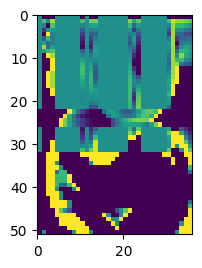

Complexities: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 2, 3, 3, 4, 7, 8, 18, 24, 26, 55, 68, 89, 91, 91, 107, 120, 128, 129, 160, 184, 187, 242, 266, 267, 269, 503, 537, 550, 561, 580, 629, 686, 779, 857, 977, 1134, 1221, 1551, 1642, 1789, 1809, 1950, 2159, 2399, 2663, 2841, 5727, 6234, 21924, 30443, 32248, 75582, 77320, 203490, 255816, 497420, 593775, 999856]
Complexities: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 2, 3, 3, 4, 7, 8, 9, 24, 26, 55, 68, 86, 89, 91, 91, 120, 128, 129, 160, 184, 187, 213, 242, 267, 269, 503, 537, 550, 561, 580, 629, 686, 779, 857, 977, 1134, 1221, 1551, 1642, 1789, 1809, 1950, 2130, 2159, 2399, 2841, 5727, 6234, 21924, 30443, 32248, 75582, 77320, 203490, 255816, 497420, 593775, 999856]
Complexities: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 2, 3, 3, 4, 7, 8, 9, 19, 26, 55, 68, 86, 89, 91, 91, 103, 120, 128, 160, 184, 187, 213, 242, 267, 

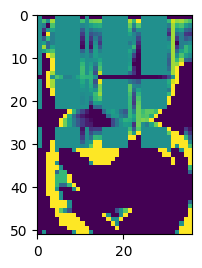

Complexities: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 2, 3, 3, 3, 4, 7, 8, 9, 16, 19, 37, 54, 71, 83, 91, 96, 102, 128, 150, 170, 184, 214, 242, 269, 399, 440, 448, 503, 537, 549, 549, 580, 625, 629, 782, 993, 1134, 1363, 1642, 1789, 1809, 1818, 1919, 1950, 2159, 3990, 4582, 21924, 24354, 32248, 61856, 75582, 203490, 255816, 497420, 593775, 999856]
Generating all variants in row 25 with [1.00 1.00 1.00 -1.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
 0.00 -1.00 1.00 1.00 1.00 0.00 0.00]
Generated     45 variants for assumed complexity {495|83.0}
Complexities: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 2, 3, 3, 3, 4, 7, 7, 8, 16, 19, 27, 29, 54, 71, 91, 96, 102, 128, 150, 170, 184, 214, 242, 269, 399, 439, 440, 448, 503, 537, 549, 580, 625, 629, 782, 993, 1134, 1363, 1642, 1789, 1809, 1818, 1919, 1950, 2159, 3990, 4582, 219

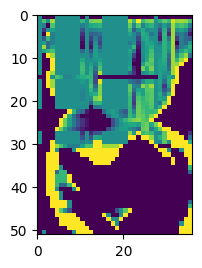

Complexities: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 2, 3, 3, 3, 3, 5, 5, 7, 8, 9, 17, 29, 35, 47, 52, 54, 71, 96, 128, 150, 184, 214, 242, 269, 399, 439, 440, 448, 500, 503, 537, 549, 580, 625, 629, 872, 926, 993, 1134, 1145, 1228, 1314, 1818, 1950, 2159, 3990, 4582, 21924, 24354, 32248, 61856, 75582, 203490, 255816, 497420, 593775, 999856]
Complexities: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 2, 3, 3, 3, 3, 5, 5, 7, 8, 9, 17, 29, 33, 35, 47, 54, 71, 96, 128, 150, 184, 214, 242, 269, 399, 439, 440, 448, 500, 503, 537, 549, 580, 625, 629, 741, 872, 982, 993, 1134, 1145, 1314, 1818, 1950, 2159, 3990, 4582, 21924, 24354, 32248, 61856, 75582, 203490, 255816, 497420, 593775, 999856]
Generating all variants in row 19 with [1.00 1.00 1.00 -1.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
 0.00 -1.00 1.00 1.00 1.00 1.00 1.00]
G

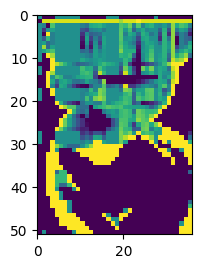

Complexities: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 2, 2, 3, 3, 3, 5, 5, 7, 8, 9, 14, 17, 29, 33, 43, 47, 50, 71, 96, 128, 150, 171, 184, 215, 255, 320, 351, 400, 440, 448, 503, 508, 537, 549, 580, 629, 741, 872, 931, 982, 1134, 1145, 1314, 1950, 2159, 2553, 4582, 12469, 16215, 21924, 32248, 75582, 203490, 255816, 397936, 593775, 999856]
Did obvious fill in row 37 of [1.00 -1.00 -1.00 0.00 1.00 -1.00 -1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00
 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00
 1.00 1.00 1.00 1.00 1.00 1.00 1.00] into [1.00 -1.00 -1.00 -1.00 1.00 -1.00 -1.00 1.00 1.00 1.00 1.00 1.00 1.00
 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00
 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00]
Did obvious fill in col 4 of [0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
 0.00 0.00 0.00 0.00 0.00 0.00 -1.00 1.00 1.00 -1.00 -1.00 0.00 0.00 0.00
 0.00 0.00 1.00 1.00 1.00 1.00 -1.00 

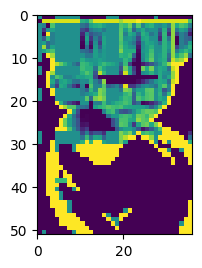

Complexities: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 2, 2, 3, 3, 3, 3, 3, 5, 5, 7, 7, 9, 29, 33, 43, 45, 47, 50, 87, 96, 128, 147, 150, 215, 255, 320, 351, 400, 406, 440, 446, 448, 464, 503, 537, 538, 549, 592, 629, 786, 931, 1134, 1145, 1876, 1950, 2043, 2159, 2615, 8302, 21924, 32248, 75582, 203490, 255816, 397936, 593775, 999856]
Generating all variants in col 15 with [0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 1.00
 1.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 1.00 1.00 1.00 0.00 0.00
 0.00 -1.00 -1.00 -1.00 -1.00 -1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00
 1.00 1.00 1.00 1.00 1.00 -1.00 1.00 1.00 1.00]
Generated     92 variants for assumed complexity {134596|406.8}
Generating all variants in row 28 with [1.00 1.00 -1.00 0.00 -1.00 1.00 0.00 0.00 0.00 0.00 -1.00 0.00 -1.00
 -1.00 0.00 0.00 0.00 0.00 0.00 0.00 1.00 1.00 1.00 1.00 1.00 -1.00 0.00
 1.00 -1.00 0.00 -1.00 -1.00 -1.00 -1.00 0.00]
Generated      6 variants 

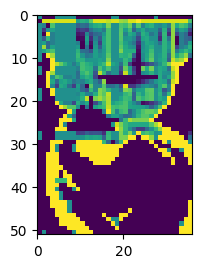

Complexities: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 3, 3, 4, 7, 9, 9, 29, 33, 35, 43, 47, 50, 59, 96, 121, 128, 147, 150, 215, 255, 256, 320, 351, 351, 352, 379, 393, 406, 429, 430, 448, 503, 580, 595, 628, 629, 1145, 1307, 1950, 2092, 2159, 8302, 21924, 32248, 75582, 162792, 255816, 397936, 593775, 999856]
Generating all variants in col 26 with [0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 1.00
 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 -1.00 1.00 0.00 0.00 0.00 -1.00
 1.00 -1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00
 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00]
Generated    684 variants for assumed complexity {116280|351.4}
Complexities: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 3, 3, 4, 7, 9, 9, 29, 33, 35, 43, 47, 50, 59, 96, 121, 128, 147, 150, 215, 255, 256, 281, 320, 351, 352, 379, 393, 406, 429, 430, 448, 503, 58

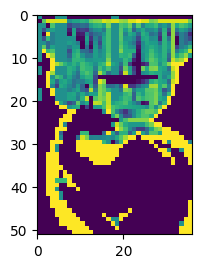

Complexities: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 5, 9, 9, 23, 33, 35, 43, 47, 50, 59, 76, 77, 97, 128, 131, 147, 150, 194, 208, 215, 255, 256, 256, 275, 281, 281, 281, 314, 429, 448, 503, 595, 629, 1046, 1145, 1673, 1950, 2159, 8302, 21924, 32248, 60465, 162792, 255816, 397936, 593775, 999856]
Complexities: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 5, 9, 9, 23, 33, 35, 43, 47, 50, 59, 76, 77, 97, 128, 131, 147, 150, 194, 208, 215, 220, 255, 256, 256, 281, 281, 281, 314, 429, 448, 503, 595, 629, 1046, 1145, 1673, 1950, 2159, 8302, 21924, 32248, 60465, 162792, 255816, 397936, 593775, 999856]
Generating all variants in col 3 with [0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
 0.00 0.00 0.00 0.00 -1.00 -1.00 1.00 1.00 1.00 1.00 1.00 -1.00 -1.00
 -1.00 -1.00 -1.00 -1.00 -1.00 -1.00 -1.00 -1.00 -1.00 -1.00 -1.00 -1.0

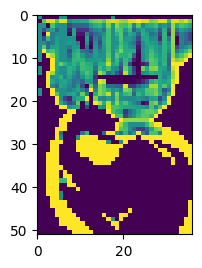

Complexities: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 3, 4, 6, 15, 16, 24, 28, 33, 43, 47, 50, 76, 77, 84, 94, 97, 115, 128, 144, 150, 166, 195, 205, 205, 215, 220, 255, 281, 314, 403, 428, 429, 448, 629, 1145, 1338, 1727, 1950, 8302, 21924, 25798, 60465, 130233, 204652, 397936, 593775, 999856]
Complexities: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 3, 4, 6, 15, 16, 18, 24, 33, 43, 47, 50, 76, 77, 84, 94, 97, 115, 115, 128, 150, 166, 195, 205, 205, 215, 220, 255, 281, 314, 343, 403, 428, 448, 629, 1145, 1338, 1727, 1950, 8302, 21924, 25798, 60465, 130233, 204652, 397936, 593775, 999856]
Complexities: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 3, 4, 6, 14, 15, 16, 24, 33, 43, 47, 50, 67, 76, 77, 94, 97, 115, 115, 128, 150, 166, 195, 205, 205, 215, 220, 255, 281, 314, 343

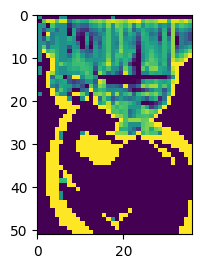

Complexities: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 4, 6, 10, 11, 13, 13, 15, 15, 15, 26, 32, 37, 43, 59, 67, 76, 102, 112, 115, 120, 133, 138, 161, 164, 195, 205, 220, 255, 257, 281, 428, 448, 629, 685, 1105, 1145, 1950, 4250, 21924, 25798, 60465, 130233, 204652, 397936, 593775, 799884]
Complexities: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 4, 6, 10, 11, 13, 13, 15, 15, 15, 26, 26, 37, 43, 59, 67, 76, 102, 112, 115, 120, 133, 138, 161, 164, 195, 205, 220, 255, 257, 281, 428, 448, 629, 685, 1105, 1145, 1950, 4250, 21924, 25798, 60465, 130233, 204652, 397936, 593775, 799884]
Complexities: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 4, 6, 10, 11, 13, 13, 15, 15, 15, 26, 26, 37, 43, 59, 67, 76, 102, 112, 115, 120, 133, 138, 161, 164, 195, 205, 220, 255, 257, 281

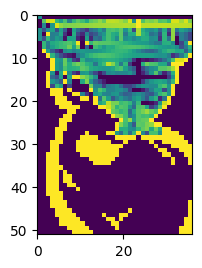

Complexities: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 6, 9, 10, 13, 13, 15, 15, 15, 20, 26, 37, 43, 43, 43, 59, 72, 76, 82, 88, 102, 115, 120, 133, 141, 164, 195, 205, 224, 255, 281, 428, 448, 452, 503, 1145, 1950, 2176, 17539, 25798, 60465, 130233, 163722, 397936, 593775, 799884]
Complexities: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 6, 9, 10, 13, 13, 15, 15, 15, 20, 26, 37, 43, 43, 43, 59, 72, 76, 82, 88, 102, 115, 120, 133, 141, 164, 195, 205, 224, 255, 281, 428, 448, 452, 503, 1145, 1950, 2176, 14031, 25798, 48372, 104186, 163722, 397936, 475020, 639907]
Did obvious fill in row 1 of [0.00 1.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 -1.00 0.00 0.00 0.00 0.00 0.00
 0.00 0.00 0.00 0.00 0.00 0.00 1.00] into [0.00 1.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00

In [ ]:
# Load our next puzzle
# rows, cols = get_test_puzzle('gridler.multisolve.json.txt')
rows, cols = get_actual_puzzle(266162)

srows = [Seq(row) for row in rows]
scols = [Seq(col) for col in cols]
field = Field(srows, scols)

prev = start
step = 0
debug_level = 0
Variant.unpacks_done = 0
start = time.perf_counter()

# Fire the solver
for advanced, processed in field.solve_step():
    step += 1
    if step % 10 == 1:
        print(f'step {step}, time taken so far: {time.perf_counter() - start:.3f} s, complexity: {field.last_complexity()}')
        field.visualize_probs()
    prev = time.perf_counter()
    if not advanced:
        break

if not field.is_solved():
    print("No possible solutions :-(  (or just can't solve them :)")
else:
    print(f"Solved in {step} steps :-)") 
    if field.more_solutions: print(f"There are multiple possible solutions and this is just one of them")
print(f" took {time.perf_counter() - start:.3f} s")
print(f"{Variant.unpacks_done=} (the expensive stuff)")
field.visualize()

# Current state:
#  Still No branching support 